In [1]:
import torch
from torch.nn import Conv2d, MaxPool2d
from common.authors_code.load_files import load_compressed_tensor, VideoReader
import matplotlib.pyplot as plt

In [ ]:
def estimate_x_t(M, x_t_prev):
  return x_t_prev + M[x_t_prev]

In [2]:
def bound_val(val, minimum, maximum):
  if minimum <= val <= maximum:
    return val

  if minimum > val:
    return minimum

  return maximum

def bound(tensor, minimum, maximum):
  for i in range(tensor.shape[0]):
    tensor[i] = bound_val(tensor[i], minimum[i], maximum[i])


def flows(M, t_steps):
  f_prev = M.clone() # F 0->1
  flow = torch.zeros((t_steps+1, M.shape[0], M.shape[1], 2))
  flow[0] = f_prev.clone()
  for t in range(1, t_steps+1):
    for x in range(M.shape[0]):
      for y in range(M.shape[1]):
        x_0 = torch.tensor((x, y))
        new_pos = x_0 + f_prev[x_0[0], x_0[1]] 
        new_pos = new_pos.type(torch.int32)
        bound(new_pos, (0, 0), torch.tensor(M.shape)-1)
        f_prev[x_0[0], x_0[1]] += M[new_pos[0], new_pos[1]]
    
    flow[t] = f_prev.clone()

    print("T: {}/{}\r".format(t, t_steps))

  return flow

In [3]:
def convert_motion_path_M(motion_path, device=torch.device("cpu")):
    return -motion_path.permute(0, 3, 2, 1)[0].to(device)

In [4]:
def convert_image(image, device=torch.device("cpu")):
    return image.permute(1, 0, 2).to(device)

In [5]:
frame = VideoReader("../data/test_data/sample_video.mp4").get_frame(0)
motion_path = load_compressed_tensor("../data/test_data/pair_video.pth")

In [6]:
M = convert_motion_path_M(motion_path)
M.shape

torch.Size([1280, 612, 2])

In [7]:
image = convert_image(torch.tensor(frame))
image.shape

torch.Size([1280, 612, 3])

In [8]:
motion_flows = flows(M, 60)
motion_flows.shape

T: 1/60
T: 2/60
T: 3/60
T: 4/60
T: 5/60
T: 6/60
T: 7/60
T: 8/60
T: 9/60
T: 10/60
T: 11/60
T: 12/60
T: 13/60
T: 14/60
T: 15/60
T: 16/60
T: 17/60
T: 18/60
T: 19/60
T: 20/60
T: 21/60
T: 22/60
T: 23/60
T: 24/60
T: 25/60
T: 26/60
T: 27/60
T: 28/60
T: 29/60
T: 30/60
T: 31/60
T: 32/60
T: 33/60
T: 34/60
T: 35/60
T: 36/60
T: 37/60
T: 38/60
T: 39/60
T: 40/60
T: 41/60
T: 42/60
T: 43/60
T: 44/60
T: 45/60
T: 46/60
T: 47/60
T: 48/60
T: 49/60
T: 50/60
T: 51/60
T: 52/60
T: 53/60
T: 54/60
T: 55/60
T: 56/60
T: 57/60
T: 58/60
T: 59/60
T: 60/60


torch.Size([61, 1280, 612, 2])

In [9]:
def get_chis(flow):
  chis = []

  for t in range(len(flow)):
    chis.append({})
    flow_t = flow[t]
    width, height = flow_t.shape[0], flow_t.shape[1]
    for x in range(width):
      for y in range(height):
        new_pos = torch.tensor([x, y]) + flow_t[x, y]
        new_pos.type(torch.int32)
        if new_pos[0] >= width or new_pos[1] >= height:
          continue

        if new_pos[0] < 0 or new_pos[1] < 0:
          continue

        new_x = int(new_pos[0])
        new_y = int(new_pos[1])
        if new_x not in chis[t]:
          chis[t][new_x] = {}

        if new_y not in chis[t][new_x]:
          chis[t][new_x][new_y] = []

        chis[t][new_x][new_y].append([x, y])

    print("T:", t, "/", len(flow), end="\r")

  return chis

In [10]:
chis = get_chis(motion_flows)

In [11]:
chis[8][826][436]

[[825, 431]]

In [12]:
def D_t(chi, D_0, Z, alpha):
  numerator_sum = 0
  denominator_sum = 0
  for x in chi:
    temp = torch.exp(Z[x[0], x[1]])
    numerator_sum += D_0[x[0], x[1]] * temp * alpha
    denominator_sum += temp * alpha


  if torch.any(denominator_sum == 0):
    return torch.tensor([0]*D_0.shape[2])


  return torch.div(numerator_sum, denominator_sum)

In [13]:
def get_alpha_t(is_vf, N):
  def alpha_t_f(t):
    return 1 - t / N

  def alpha_t_p(t):
    return t / N

  return alpha_t_f if is_vf else alpha_t_p

def generate_V(D_0, flow, Z, alpha_t, chis=None):
  coords = []
  if flow != None:
    t_steps = len(flow) - 1
  else:
    t_steps = len(chis) - 1

  for x in range(D_0.shape[0]):
      for y in range(D_0.shape[1]):
        coords.append(torch.tensor([x, y]))
  coords = torch.stack(coords)

  V = torch.zeros((t_steps+1, D_0.shape[0], D_0.shape[1], D_0.shape[2]))
  V[0] = D_0

  if chis == None:
    chis = get_chis(flow)
  for t in range(1, t_steps+1):
    print("T:", t, "/", t_steps, "\r")
    alpha = alpha_t(t)
    chi = chis[t]
    for x in chi.keys():
      for y in chi[x].keys():

        V[t][x][y] = D_t(chi[x][y], D_0, Z, alpha)

  return V

In [21]:
chis[0][0][0]

[[0, 0]]

In [14]:
def naive(first_video_frame, M, steps):
    first_video_frame = first_video_frame.clone()
    Z = torch.ones((first_video_frame.shape[0], first_video_frame.shape[1]))
    def test_alph(t):
        return 1

    flow = flows(M, steps)
    return generate_V(first_video_frame, flow, Z, test_alph)

V = naive((image/255).to(torch.device("cuda")), chis)

T: 1 / 60 
T: 2 / 60 
T: 3 / 60 
T: 4 / 60 
T: 5 / 60 
T: 6 / 60 
T: 7 / 60 
T: 8 / 60 
T: 9 / 60 
T: 10 / 60 
T: 11 / 60 
T: 12 / 60 
T: 13 / 60 
T: 14 / 60 
T: 15 / 60 
T: 16 / 60 
T: 17 / 60 
T: 18 / 60 
T: 19 / 60 
T: 20 / 60 
T: 21 / 60 
T: 22 / 60 
T: 23 / 60 
T: 24 / 60 
T: 25 / 60 
T: 26 / 60 
T: 27 / 60 
T: 28 / 60 
T: 29 / 60 
T: 30 / 60 
T: 31 / 60 
T: 32 / 60 
T: 33 / 60 
T: 34 / 60 
T: 35 / 60 
T: 36 / 60 
T: 37 / 60 
T: 38 / 60 
T: 39 / 60 
T: 40 / 60 
T: 41 / 60 
T: 42 / 60 
T: 43 / 60 
T: 44 / 60 
T: 45 / 60 
T: 46 / 60 
T: 47 / 60 
T: 48 / 60 
T: 49 / 60 
T: 50 / 60 
T: 51 / 60 
T: 52 / 60 
T: 53 / 60 
T: 54 / 60 
T: 55 / 60 
T: 56 / 60 
T: 57 / 60 
T: 58 / 60 
T: 59 / 60 
T: 60 / 60 


In [15]:
def reformat_tensor_to_image(image):
    return image.permute(1, 0, 2)

In [180]:
chi_1 = chis[1]
num = 0
for x in chi_1.keys():
    for y in chi_1[x].keys():
        point = chi_1[x][y][0]
        if point[0] != x or point[1] != y:
            num += 1
            # print(point, [x, y])

print(num, len(chi_1.keys()) * len(chi_1[0].keys()))

25726 783360


In [189]:
Z = torch.ones((image.shape[0], image.shape[1]))
num = image[0][0]/255 * torch.exp(Z[0][0]) 
den = torch.exp(Z[0][0])
# print(num, den)
print(torch.div(num, den))

def test_alph(t):
    return 1

print(D_t([[0,0]], image/255, Z, 1))
V[1][0][0]

tensor([0.2902, 0.2706, 0.1451])
tensor([0.2902, 0.2706, 0.1451])


tensor([0.4588, 0.4863, 0.4235])

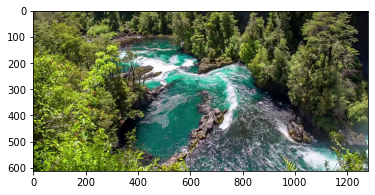

In [16]:
plt.imshow(reformat_tensor_to_image(image/255))

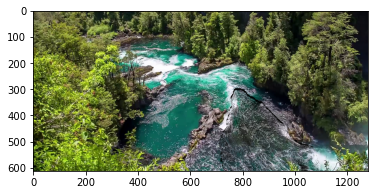

In [18]:
plt.imshow(reformat_tensor_to_image(V[60]))

In [ ]:
def reverse_tensor(tensor):
  as_list = list(tensor)
  as_list.reverse()
  return torch.stack(as_list)

In [ ]:
def get_alpha(t):
  pass

def get_aplha_inverse(t): # assumes t is 0-1
  return 1 - t

def splat(t_0, t_1):
  alpha_0 = get_alpha(t_0)
  alpha_1 = get_aplha_inverse(alpha_0)
  return alpha_0 * t_0 + alpha_1 * t_1

In [ ]:
def symetrical_splatting(D_0, t_steps, M, Z):
  V_f = generate_V(D_0, t_steps,  M, Z)
  V_p = generate_V(D_0, t_steps, -M, Z)
  V_p = reverse_tensor(V_p)
  return splat(V_f, V_p)


In [ ]:
def joint_splatting_training(D_0, D_N, t_steps, M, Z):
  V_f = generate_V(D_0, t_steps,  M, Z)
  V_p = generate_V(D_N, t_steps, -M, Z)
  return splat(V_f, V_p)

In [ ]:
def get_motion_estimation_network(): # Pix2PixHD netowork
  # Hourglass shape with skip connections
  pass 

In [ ]:
def motion_estimation_descriminator(x): # Basic Descriminator
  # convs 
  # pools
  layers = [
      [10, 1],
      [1, 2],
  ]

  for layer in layers:
    filters, stride = layer
    x = Conv2d(filters, stride)(x)
    x = MaxPool2d()(x)

  return x

In [ ]:
def get_encoder():
  # conv
  # pools
  pass

In [ ]:
def get_decoder():
  # conv large padding less filters
  pass

In [ ]:
def get_enc_dec_discriminator():
  pass

In [ ]:
def get_D_Z(I, encoder):
  D_Z = encoder(I)
  Z = D_Z[0]
  D = D_Z[1:]
  return D, Z


In [ ]:
!pip install av
!pip install py-lz4framed
import av
import torch
import numpy as np
import pickle
import lz4framed


def load_compressed_tensor(filename):
    retval = None
    with open(filename, mode='rb') as file:
        retval = torch.from_numpy(pickle.loads(lz4framed.decompress(file.read())))
    return retval

     |████████████████████████████████| 128 kB 4.0 MB/s 
  Created wheel for py-lz4framed: filename=py_lz4framed-0.14.0-cp37-cp37m-linux_x86_64.whl size=346641 sha256=2fdc402030aa1a5b8bce20f926e89a8f68ebcf79a141372fab689cfc9653aa08
  Stored in directory: /root/.cache/pip/wheels/5c/9c/8e/5d008dfcbb83cfb99763f100d10b6b2d953274f48744b7be81
Successfully built py-lz4framed


In [ ]:
t = load_compressed_tensor("ex_motion.pth")

In [ ]:
t.shape

torch.Size([1, 2, 612, 1280])